# Global

In [578]:
# METTI COMMENTI STILE PEP8 PER OGNI FUNZIONE
global_var = {
    # Data
    'data_path': "/content/vessel_data",
    'prefix': "https://drive.google.com/uc?export=",
    'bifurcating_data_id': "download&id=1bzXusjOMgh-5hnw6RDNc03UUktQixtL4",
    'single_data_id': "download&id=19AHhDU1UWBzpG33wlB1r7b6sH3lMVly5",
    'current_name': "bifurcating",

    # Datasets
    'single_path': "./single/single.hdf5",
    'bifurcating_path': "./bifurcating/bifurcating.hdf5",
    'dataset_path': "./dataset.hdf5",
    'train_path': "./train.hdf5",
    'test_path': "./test.hdf5",

    # Datasets quality check
    'data_length': 2000,
    'data_keys': ['face', 'inlet_idcs', 'pos', 'pressure', 'wss'],

    # Geometric algebra
    'ga_dimension': 16,

    # Train
    'train_test_split': 0.8,
    'validation_split': 0.1,
    'batch_size': 32,
    'num_workers': 2,
}

# Imports

In [386]:
!pip install wget pytorch_lightning torchvision --quiet

In [552]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import pytorch_lightning as pl
import pandas as pd
import re
import sys
import torch
import wget
import zipfile

from pytorch_lightning import LightningModule
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

# Dataset

## Download datasets

In [388]:
def bar_progress(current,total,width = 80):
    """
        Simple bar to track the download list of links
        associated with patches in the dataset

        Args:
            current: current byte number
            total: total byte number
            width: visual length of the bar
    """
    progress = current / total * 100
    progress_string = f"{progress} % [{current} / {total}] bytes"
    name = global_var['current_name']
    description = f"[{name}] Recovering links: " + progress_string
    sys.stdout.write("\r" + description)
    sys.stdout.flush()

In [389]:
def get_links_list(list_link,dataset_name):
    """
        Download the file with the links referred to
        the dataset patches

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log

        Returns:
            links: list of the zipped dataset patches
    """
    global_var['current_name'] = dataset_name
    list_name = wget.download(list_link,bar = bar_progress)
    links = pkl.load(open(list_name, 'rb'))
    os.remove(list_name)
    os.makedirs(dataset_name, exist_ok = True)

    return links

In [390]:
def unzip_data_patches(links,dataset_name,debug):
    """
        Unzip the downloaded file patches to obtain the respective HDF5
        file within them, cleaning up excess files when finished

        Args:
            links: list with the links referred to file to download
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function

        Returns:
            hdf5_patches: list of HDF5 files
    """
    cnt = 0 if debug else None
    hdf5_patches = []

    tqdm_desc = f"[{dataset_name}] Downloading and unzipping data patches"
    for link in tqdm(links,desc = tqdm_desc):
        name = wget.download(link)
        with zipfile.ZipFile(name, 'r') as zip_ref:
            zip_ref.extractall("/content/")
            hdf5_patches.append(name.replace(".zip",".hdf5"))
            os.remove(name)
            if debug:
                cnt +=1
            if debug and cnt > 3:
                break
    return hdf5_patches

In [391]:
def compose_dataset(dataset_file,dataset_name,hdf5_patches):
    """
        Merge several HDF5 files into one,

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name
            hdf5_patches: list of file to merge
    """
    with h5py.File(dataset_file, 'w') as file_dest:
        tqdm_desc = f"[{dataset_name}] Composing HDF5 full dataset"
        for file_origine in tqdm(hdf5_patches,desc = tqdm_desc):
            percorso_file_origine = os.path.join("/content/", file_origine)

            with h5py.File(percorso_file_origine, 'r') as file_orig:
                for gruppo_nome, gruppo in file_orig.items():
                    gruppo_dest = file_dest.create_group(gruppo_nome)

                    for data_name, dataset in gruppo.items():
                        gruppo_dest.create_dataset(data_name, data=dataset[()])

    for file in hdf5_patches:
        percorso_file = os.path.join("/content/", file)
        os.remove(percorso_file)

In [392]:
def quality_check(dataset_file,dataset_name):
    """
        Check that the final dataset meets the standards

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name used for log

        Returns:
            (Boolean): logical result of the check
    """
    print(f"[{dataset_name}]\033[1m Dataset quality check \033[0m")

    with h5py.File(dataset_file, 'r') as dataset:
        # Check correct length
        len_condition = (len(dataset) == global_var['data_length'])
        if len_condition:
            error_str = "All samples present in the dataset \u2714"
            print(f"[{dataset_name}] " + error_str)
        else:
            missing_samples = global_var['data_length'] - len(dataset)
            error_str = "Not all samples are in the dataset \u2718"
            print(f"[{dataset_name}] " + error_str)
            if missing_samples > 1:
                print(f"[{dataset_name}] \t -> {missing_samples} is missing")
            else:
                print(f"[{dataset_name}] \t -> {missing_samples} are missing")
            return False

        # Check correct keys
        keys_condition = True
        for sample in list(dataset.keys()):
            correct_keys = list(dataset[sample].keys())
            current_keys = global_var['data_keys']
            keys_condition = keys_condition and (correct_keys == current_keys)
            if not keys_condition:
                problematic_sample = sample
                break
        if keys_condition:
            print(f"[{dataset_name}] All samples keys are correct \u2714")
        else:
            print(f"[{dataset_name}] Error in samples keys \u2718")
            print(f"[{dataset_name}] \t -> Check {problematic_sample}")
            return False

        # Check correct ordering
        ordering_condition = True
        numbers = [re.search(r'_\d+', s).group()[1:] for s in dataset.keys()]
        for n in range(len(numbers)):
            counter = f'{n:04d}'
            ordering_condition = ordering_condition and (numbers[n] == counter)
            if numbers[n] != counter:
                problematic_sample = counter
            break

        if ordering_condition:
            print(f"[{dataset_name}] Samples are ordered \u2714")
        else:
            print(f"[{dataset_name}] Samples are NOT ordered \u2718")
            print(f"[{dataset_name}] \t -> Check {counter}")
            return False

    return True

In [393]:
def download_dataset(list_link, dataset_name, debug):
    """
        Download the dataset divided into several patches,
        assemble it and check that the operation is successful

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function
    """
    dataset_file = dataset_name + "/" + dataset_name + ".hdf5"
    if not os.path.exists(dataset_name):
        links = get_links_list(list_link,dataset_name)
        hdf5_patches = unzip_data_patches(links,dataset_name,debug)
        compose_dataset(dataset_file,dataset_name,hdf5_patches)
        check = quality_check(dataset_file,dataset_name)

        if check:
            success_string = "Dataset correctly downloaded \033[0m\u2714"
            print(f"[{dataset_name}] \u2714\033[1m " + success_string)
        else:
            error_string = "Dataset download failed \033[0m\u2718"
            print(f"[{dataset_name}] \u2718\033[1m " + error_string)
    else:
        done_string = f"Dataset is already available in {dataset_file}"
        print(f"[{dataset_name}] " + done_string)

In [ ]:
bifurcating_link = global_var['prefix'] + global_var["bifurcating_data_id"]
download_dataset(
    list_link = bifurcating_link,
    dataset_name = "bifurcating",
    debug = False
)

[bifurcating] Recovering links: 100.0 % [8708 / 8708] bytes

[bifurcating] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Dataset quality check 
[bifurcating] All samples present in the dataset ✔
[bifurcating] All samples keys are correct ✔
[bifurcating] Samples are ordered ✔
[bifurcating] ✔ Dataset correctly downloaded ✔


In [ ]:
single_link = global_var['prefix'] + global_var["single_data_id"]
download_dataset(
    list_link = single_link,
    dataset_name = "single",
    debug = False
)

[single] Recovering links: 100.0 % [8708 / 8708] bytes

[single] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Dataset quality check 
[single] All samples present in the dataset ✔
[single] All samples keys are correct ✔
[single] Samples are ordered ✔
[single] ✔ Dataset correctly downloaded ✔


## Train and test data

In [394]:
def copy_data(source, destination, new_sample, old_sample, label):
    destination.create_group(new_sample)
    for field in list(source[old_sample].keys()):
        new_field_data = source[old_sample][field][()]
        destination[new_sample].create_dataset(field, data = new_field_data)

    destination[new_sample].create_dataset('label', data = np.array([label]))

In [395]:
def shuffle_dataset(temp_dataset,dataset):
    with h5py.File(temp_dataset, 'r') as file:
        # Extract group names (assuming they are 'sample_0000', etc.)
        sample_names = list(file.keys())

        # Shuffle indices
        shuffled_indices = np.random.permutation(len(sample_names))

        # Create a new shuffled HDF5 file
        with h5py.File(dataset, 'w') as shuffled_file:
            values = enumerate(shuffled_indices)
            iters = len(shuffled_indices)
            shuffle_desc = '[LOG] Shuffling dataset'

            for new_index, old_index in tqdm(
                values,
                total = iters,
                desc = shuffle_desc
            ):
                sample = f'sample_{new_index:04d}'
                old_name = f'sample_{old_index:04d}'
                shuffled_file.create_group(sample)
                for field in file[old_name]:
                    shuffled_file[sample][field] = file[old_name][field][()]

    os.remove(temp_dataset)

In [396]:
def train_test_split(dataset):
    with h5py.File(dataset, 'r') as file:
        total_rows = len(file)

        # Calculates the number of rows for each set
        train_rows = int(global_var['train_test_split'] * total_rows)
        test_rows = total_rows - train_rows

        if not os.path.exists(global_var['train_path']):
            # Create a new HDF5 file for the training set
            with h5py.File(global_var['train_path'], 'w') as train_file:
                iters = range(train_rows)
                train_desc = "[LOG] Composing train set"

                for i in tqdm(iters,desc = train_desc):
                    sample = f'sample_{i:04d}'
                    train_file.create_group(sample)

                    for field in file['sample_0000']:
                        train_file[sample][field] = file[sample][field][()]

        if not os.path.exists(global_var['test_path']):
            # Create a new HDF5 file for the test set
            with h5py.File(global_var['test_path'], 'w') as test_file:
                iters = range(train_rows, total_rows)
                test_desc = "[LOG] Composing test set"

                for i in tqdm(iters,desc = test_desc):
                    sample = f'sample_{i:04d}'
                    test_file.create_group(f'sample_{i:04d}')

                    for field in file['sample_0000']:
                        sample = f'sample_{i:04d}'
                        test_file[sample][field] = file[sample][field][()]

    os.remove(dataset)

In [397]:
def merge_datasets(single_path,bifurcating_path,debug = False):
    train_condition = os.path.exists(global_var['train_path'])
    test_condition = os.path.exists(global_var['test_path'])
    start_condition =  train_condition and test_condition

    if debug or not start_condition:
        with h5py.File(single_path, 'r') as single, \
            h5py.File(bifurcating_path, 'r') as bifurcating:
            signle_len = range(len(single))
            bifurcating_len = range(len(bifurcating))

            dataset_path = global_var['dataset_path']
            temp_dataset = dataset_path.replace(".hdf5", "_temp.hdf5")
            with h5py.File(temp_dataset, 'w') as dataset:
                single_desc = "[single] Copying data"
                for single_idx in tqdm(signle_len, desc = single_desc):
                    sample_name = f'sample_{single_idx:04d}'
                    label = 0
                    copy_data(
                        source = single,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = sample_name,
                        label = label
                     )

                bifurcating_desc = "[bifurcating] Copying data"
                for bif_idx in tqdm(bifurcating_len, desc = bifurcating_desc):
                    sample_name = f'sample_{bif_idx + 2000:04d}'
                    old_sample_name = f'sample_{bif_idx:04d}'
                    label = 1
                    copy_data(
                        source = bifurcating,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = old_sample_name,
                        label = label
                     )

        shuffle_dataset(temp_dataset,global_var['dataset_path'])
        train_test_split(global_var['dataset_path'])
    else:
        print("[LOG] Train and test sets already available")

In [ ]:
merge_datasets(
    single_path = global_var['single_path'],
    bifurcating_path = global_var['bifurcating_path'],
    debug = True
)

[single] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[bifurcating] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[LOG] Shuffling dataset:   0%|          | 0/4000 [00:00<?, ?it/s]

## Embedding in geometric algebra

In [398]:
def get_pos_mv(pos):
    mv = torch.zeros(pos.shape[0], global_var['ga_dimension'])

    mv[..., 14] = 1 # homogeneous coordinates
    mv[..., 11] = pos[..., 0] # x-coordinate of pos
    mv[..., 12] = pos[..., 1] # y-coordinate of pos
    mv[..., 13] = pos[..., 2] # z-coordinate of pos

    return mv.unsqueeze(0)

In [399]:
def get_face_mv(face):
    mv = torch.zeros(face.shape[0], global_var['ga_dimension'])

    mv[..., 2] = face[..., 0]
    mv[..., 3] = face[..., 1]
    mv[..., 4] = face[..., 2]

    return mv.unsqueeze(0)

In [400]:
def get_wss_mv(wss):
    mv = torch.zeros(wss.shape[0], global_var['ga_dimension'])

    mv[..., 0] = 1 # homogeneous coordinates

    mv[..., 5] = 0.5 * wss[..., 0]
    mv[..., 6] = 0.5 * wss[..., 1]
    mv[..., 7] = 0.5 * wss[..., 2]

    return mv.unsqueeze(0)

In [401]:
def get_inlet_mv(inlet):
    mv = torch.zeros(inlet.shape[0], global_var['ga_dimension'])

    mv[..., 0] = inlet

    return mv.unsqueeze(0)

In [402]:
def get_pressure_mv(pressure):
    mv = torch.zeros(pressure.shape[0], global_var['ga_dimension'])

    mv[..., 15] = pressure

    return mv.unsqueeze(0)

In [403]:
def embed_data(sample):
    # 'pos' property modeled as a point
    input_pos = torch.tensor(np.array(sample['pos']))
    pos_mv = get_pos_mv(input_pos)

    # 'face' property modeled as a plane
    input_face = torch.tensor(np.array(sample['face']))
    face_mv = get_face_mv(input_face)

    # 'wss' property modeled as a translation
    input_wss = torch.tensor(np.array(sample['wss']))
    wss_mv = get_wss_mv(input_wss)

    # 'inlet' modeled as a scalar
    input_inlet = torch.tensor(np.array(sample['inlet_idcs']))
    inlet_mv = get_inlet_mv(input_inlet)

    # 'pressure' modeled as a scalar
    input_pressure = torch.tensor(np.array(sample['pressure']))
    pressure_mv = get_pressure_mv(input_pressure)

    total_mvs = [pos_mv, face_mv, wss_mv,inlet_mv, pressure_mv]

    return total_mvs

## Pytorch dataset

In [404]:
class VesselDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.transform = transforms.Compose([embed_data])
        with h5py.File(file_path, 'r') as file:
            self.sample_names = list(file.keys())


    def __len__(self):
        return len(self.sample_names)


    def __getitem__(self, index):
        sample_name = self.sample_names[index]

        with h5py.File(self.file_path, 'r') as file:
            multivector = self.transform(file[sample_name])
            label = file[sample_name]['label']

        return multivector,label

## Lightning DataModule

In [405]:
class VesselDataModule(pl.LightningDataModule):
    def __init__(self,bifurcating_path,single_path,train_path,test_path):
        super().__init__()
        self.bifurcating_path = bifurcating_path
        self.single_path = single_path
        self.train_path = train_path
        self.test_path = test_path



    def prepare_data(self):
        id = global_var['bifurcating_data_id']
        bifurcating_link = global_var['prefix'] + id
        download_dataset(
            list_link = bifurcating_link,
            dataset_name = "bifurcating",
            debug = False
         )
        id = global_var['single_data_id']
        single_link = global_var['prefix'] + id
        download_dataset(
            list_link = single_link,
            dataset_name = "single",
            debug = False
         )
        merge_datasets(
            single_path = self.single_path,
            bifurcating_path = self.bifurcating_path,
            debug = False
         )


    def setup(self, stage = None):
        if stage == "fit" or stage is None:
            train_dataset = VesselDataset(self.train_path)
            train_len = train_dataset.__len__()
            validation_len = int(train_len * global_var['validation_split'])
            train_val_split = [train_len - validation_len,validation_len]

            splitted_data = random_split(train_dataset, train_val_split)
            self.data_train, self.data_val = splitted_data

        if stage == "test" or stage is None:
            self.data_test = VesselDataset(self.test_path)

        if stage == "predict" or stage is None:
            pass


    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )


    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )


    def test_dataloader(self):
        return DataLoader(
            self.data_test,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )


    def predict_dataloader(self):
        return None

In [ ]:
data_module = VesselDataModule(
    bifurcating_path = global_var['bifurcating_path'],
    single_path = global_var['single_path'],
    train_path = global_var['train_path'],
    test_path = global_var['test_path']
)

# EDA

## Data statistics

In [612]:
def data_statistics(file_path):
    with h5py.File('train.hdf5', 'r') as file:
        wss_values = file['sample_0000']['wss'][:]
        pressure_values = file['sample_0000']['pressure'][:]
        position_values = file['sample_0000']['pos'][:]
        faces_values = file['sample_0000']['face'][:]
        inlet_idcs_values = file['sample_0000']['inlet_idcs'][:]

    df_pressure = pd.DataFrame(
        pressure_values * 1e-3,
        columns = ['Pressure']
    ).describe()

    df_wss = pd.DataFrame(
        wss_values,
        columns = ['WSS_x', 'WSS_y', 'WSS_z']
    ).describe()

    df_position = pd.DataFrame(
        position_values,
        columns = ['Position_x', 'Position_y', 'Position_z']
    ).describe()

    df_face = pd.DataFrame(
        faces_values,
        columns = ['Face_x', 'Face_y', 'Face_z']
    ).describe()

    df_inlet = pd.DataFrame(
        inlet_idcs_values,
        columns = ['Inlet']
    ).describe()

    df = pd.concat([
        df_pressure,
        df_wss,
        df_position,
        df_face,
        df_inlet
    ],axis = 1)

    df.iloc[1:] = df.iloc[1:].applymap('{:.4f}'.format)
    display(df)

In [613]:
data_statistics(global_var['train_path'])

,Pressure,WSS_x,WSS_y,WSS_z,Position_x,Position_y,Position_z,Face_x,Face_y,Face_z,Inlet
count,17598.0,17598.0,17598.0,17598.0,17598.0,17598.0,17598.0,35192.0,35192.0,35192.0,871.0
mean,133.4133,-4.3045,2.7798,7.2668,-0.3591,0.2248,1.1390,7549.3577,11156.7527,7585.3016,16127.2113
std,0.1016,3.3128,5.3134,4.0812,0.2982,0.3617,0.6279,4966.9929,4366.6525,5008.2487,2281.9235
min,133.2453,-29.0012,-56.1444,-4.5765,-1.0027,-0.6472,-0.0271,0.0000,0.0000,0.0000,3202.0000
25%,133.3281,-6.2378,0.0000,3.9743,-0.5957,-0.0258,0.6046,3295.7500,8132.0000,3308.7500,16239.5000
50%,133.4029,-3.5959,3.2512,8.0034,-0.3553,0.2027,1.2934,6991.0000,12217.0000,7030.5000,16755.0000
75%,133.5114,-1.9048,6.1303,9.8331,-0.1247,0.4921,1.6725,11273.0000,14767.2500,11317.0000,17214.5000
max,133.7323,1.5642,28.9696,36.0790,0.2031,0.9990,2.1384,17597.0000,17597.0000,17597.0000,17597.0000


## Dataset balancing

In [482]:
def read_labels(file_path):
    labels = []

    with h5py.File(file_path, 'r') as file:
        for sample in list(file.keys()):
            labels.append(file[sample]['label'][0])

    single_labels = labels.count(0)
    bifurcating_labels = labels.count(1)

    return single_labels,bifurcating_labels

In [491]:
def autolabel(ax,bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            '{}'.format(height),
            xy = (bar.get_x() + bar.get_width() / 2, height),
            xytext = (0, 4),
            textcoords = "offset points",
            ha = 'center',
            va = 'bottom',
            weight = 'bold',
            size = 12
         )

In [492]:
def check_label_balance(train_file_path):
    labels = read_labels(train_file_path)
    categories = ['Single', 'Bifurcating']

    color_0 = (0.0, 0.4, 1.0)
    color_1 = (1.0, 0.6, 0.0)
    bar_width = 0.8

    fig, ax = plt.subplots(figsize = (8,5))

    bars = ax.bar(
        categories,
        labels,
        color = [color_0, color_1],
        width = bar_width,
        align = 'center'
     )

    ax.set_xlabel('Label')
    ax.set_ylabel('Occurence')
    ax.set_title('Counting Labels in the train set', weight = 'bold')

    autolabel(ax,bars)

    plt.ylim(ymax = max(labels) + 200)
    plt.show()

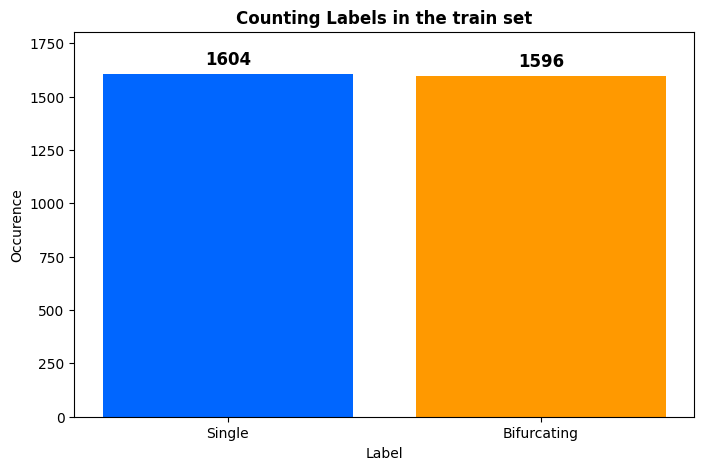

In [493]:
check_label_balance(global_var['train_path'])

## Scatter plot

In [534]:
def get_scatter_data(file_path):
    single_pressures = []
    single_wss = []
    bifurcating_pressures = []
    bifurcating_wss = []

    with h5py.File(file_path, 'r') as file:
        for sample in list(file.keys()):
            #Shift to mPa (millPascal)
            pressure = file[sample]['pressure'][()]
            mean_pressure = np.array(pressure).mean() * 1e-3
            mean_wss = np.array(file[sample]['wss'][()]).mean()

            if file[sample]['label'][0] == 0:
                single_pressures.append(mean_pressure)
                single_wss.append(mean_wss)
            else:
                bifurcating_pressures.append(mean_pressure)
                bifurcating_wss.append(mean_wss)

    pressures = [single_pressures,bifurcating_pressures]
    wss = [single_wss,bifurcating_wss]

    return pressures,wss

In [549]:
def scatter_plot(file_path):
    pressures,wss = get_scatter_data(file_path)

    fig, ax = plt.subplots(figsize = (10,7))

    ax.scatter(
        pressures[0],
        wss[0],
        label = 'Single',
        alpha = 0.3
     )
    ax.scatter(
        pressures[1],
        wss[1],
        label = 'Bifurcating',
        alpha = 0.3
     )

    ax.set_xlabel('Pressure')
    ax.set_ylabel('WSS (Wall Shear Stress)')
    ax.set_title('Scatterplot between WSS e Pressure', weight = 'bold')

    ax.legend()
    plt.show()

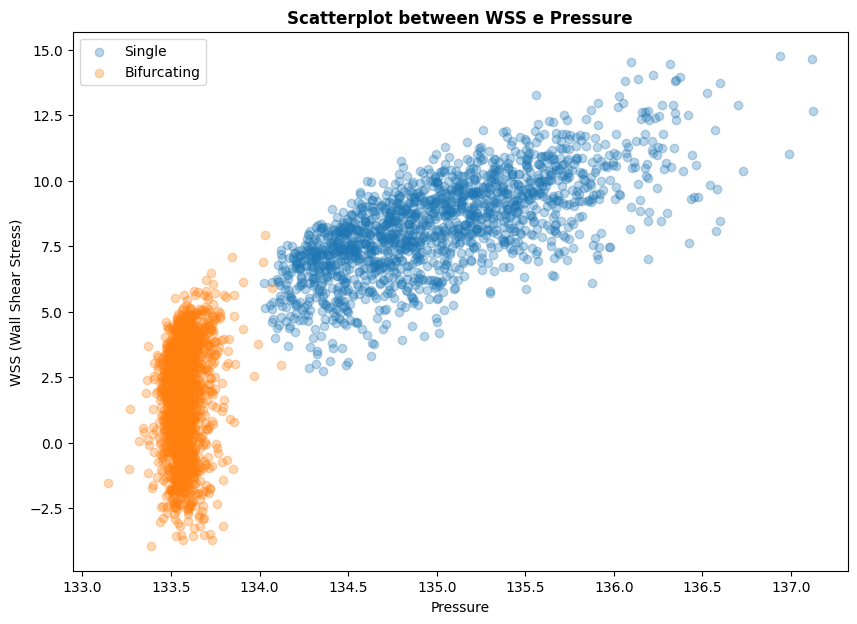

In [551]:
scatter_plot(global_var['train_path'])